Current planned updates:

-add gui to edit the graph (line colors, legend size and captions, overall graph size,tickmark placement and spacing,changing the limits of the x-axis for PDOS, probably more)

-add the spin polarized stuff too

-Probably lots of bug fixes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import glob
import os.path
import pandas as pd
import re
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

In [2]:
print("please enter the compound name")
compound = input()
print("are all files in the same folder? (y/n)(don't say no)")
folderchoice = input()
if folderchoice == 'y':
    print("Input folder location")
    file_directory = input()
    
if folderchoice == 'y':
        #finding the fermi level
    fermi = np.array([])

    rootname = file_directory+ '/' + compound +'.scf.out' #puts together the file name that it's looking for
    #it's possible that when running it in a directory that isn't structured like this you need to flip the "/" to be "\", because I noticed that my computer I think has the file directories use the other slash, i'm not sure though
    
    readfile = open(rootname) #reads file and splits it up into a bunch of lines
    xyz = readfile.readlines()

    for line in xyz: #goes through line by line and looks for the line which has the fermi level
        first = 'hello'
        words = line.split()
        if words != []:
             first = words[0]
        if first == "the":
            if words[1] == "Fermi":
                fermi = np.append(fermi, float(words[4])) #I'm pretty sure I could've done words[-1] but I was being dumb, I'll check later
    print("Fermi level is" + str(fermi))

    rootname = file_directory + '/' + compound + '.bands.in' #looks for the bands file which has the symmetry points symbols

    sym_points = np.array([])
    sym_xvalue = np.array([])
    kflag = 0


    readfile = open(rootname) #same as above
    xyz = readfile.readlines()

    for line in xyz: #same as above
        first = 'hello'
        words = line.split()
        if words != []:
             first = words[0]
        if first == "K_POINTS":
            kflag = 1  #identifies where the k points start being listed
        if kflag == 1:
            hi = "hello"
            try:   #if there aren't five words then it just goes to the next line, this just skips the first line effectively
                sym_points = np.append(sym_points, words[5]) 
            except:
                pass

    kflag = 0

    rootname = file_directory + '/' + compound + '.plotband.out'  #looks for the plotband file which has the x values of the symmetry points

    readfile = open(rootname) #same as above
    xyz = readfile.readlines()


    for line in xyz:
        first = 'hello'
        words = line.split()
        if words != []:
             first = words[0]
        if first == "high-symmetry":  #identifies where the high symmetry points are and takes the x values for them
            #this is just because of an error with the initial data set because I don't feel like figuring out why there is that extra point
            if words[-1] != '6.3718':
                sym_xvalue = np.append(sym_xvalue, float(words[-1]))
            else:
                print(hi)
        if first == "Range:": #for some reason the first row isn't formatted the same way but it does have a point, so I just need something for that specifically. This may cause issues in the future so check file formatting if this line bugs out
            sym_xvalue = np.append(sym_xvalue, float(words[-1]))

if folderchoice == 'n':
    #finding the fermi level
    fermi = np.array([])

    #these lines allow for user input when choosing not these files, which would be the primary way to do it. it requires the full path name from whatever directory this file is in

    print("enter file directory path for *.scf.out to find the fermi level")
    rootname = input()+ '/' + compound +'.scf.out'

    readfile = open(rootname)
    xyz = readfile.readlines()

    for line in xyz:
        first = 'hello'
        words = line.split()
        if words != []:
             first = words[0]
        if first == "the":
            if words[1] == "Fermi":
                fermi = np.append(fermi, float(words[4]))
    print(fermi)

    #these lines allow for user input when choosing not these files, which would be the primary way to do it. it requires the full path name from whatever directory this file is in

    print("enter file directory path for *.bands.in")
    rootname = input()+ '/' + compound + '.bands.in'

    sym_points = np.array([])
    sym_xvalue = np.array([])
    kflag = 0



    readfile = open(rootname)
    xyz = readfile.readlines()

    for line in xyz:
        first = 'hello'
        words = line.split()
        if words != []:
             first = words[0]
        if first == "K_POINTS":
            kflag = 1
        if kflag == 1:
            hi = "hello"
            try: 
                sym_points = np.append(sym_points, words[5])
            except:
                pass

    kflag = 0

    #these lines allow for user input when choosing not these files, which would be the primary way to do it. it requires the full path name from whatever directory this file is in

    print("enter file directory path for *.plotband.out")
    rootname = input()+ '/' + compound + '.plotband.out'

    readfile = open(rootname)
    xyz = readfile.readlines()


    for line in xyz:
        first = 'hello'
        words = line.split()
        if words != []:
             first = words[0]
        if first == "high-symmetry":
            #this is just because of an error with the initial data set because I don't feel like figuring out why there is that extra point
            if words[7] != '6.3718':
                sym_xvalue = np.append(sym_xvalue, float(words[7]))
            else:
                pass
        if first == "Range:":
            sym_xvalue = np.append(sym_xvalue, float(words[15]))  #ugh just repeat all the documentation from above, it's (probably) the same anyways


please enter the compound name
CaCO3
are all files in the same folder? (y/n)(don't say no)
y
Input folder location
CaCO3_PDOS_Bands
Fermi level is[7.4837]


In [3]:
#for entering the directory with the required files manually
if folderchoice == 'n':
    print("Enter directory with PDOS Files")
    directory = input()
    file_location = os.path.join(directory,"*.pdos_atm#*")
if folderchoice == 'y':
    file_location = os.path.join(file_directory,"*.pdos_atm#*")

pdos_files = glob.glob(file_location)
print(pdos_files)

['CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#4(d)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#3(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#19(O)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#19(O)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#18(O)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#18(O)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#17(C)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#17(C)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#16(O)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#16(O)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#15(C)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#15(C)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#14(O)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#14(O)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#13(O)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#13(O)_wfc#1(s)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#12(O)_wfc#2(p)', 'CaCO3_PDOS_Bands/CaCO3.pdos_atm#12(O)_wfc#1(

In [4]:
#for entering the directory with the required files manually

if folderchoice == 'n':
    print("Enter directory with PDOS Files")
    directory = input()
    file_location = os.path.join('pdos_bands',"*.pdos_atm#*")
    pdos_files = glob.glob(file_location)
    #print(pdos_files)
    element = np.array([])
    atm_num = np.array([])
    wfc_num = np.array([])
    orbital = np.array([])
    datafile = np.array([])
    for file in pdos_files:
        match = re.search(file_directory + '(\D+)(\d?).pdos_atm#(\d+)((\D+))_wfc#(\d+)((\D+))', file)
        element = np.append(element,match.group(4))
        atm_num = np.append(atm_num,match.group(3))
        wfc_num = np.append(wfc_num,match.group(6))
        orbital = np.append(orbital,match.group(7))
        datafile = np.append(datafile,file)

if folderchoice == 'y':
    file_location = os.path.join(file_directory,"*.pdos_atm#*")

    pdos_files = glob.glob(file_location)
    #print(pdos_files)

    #create arrays to hold elements which will go into the Dataframe of files and properties
    element = np.array([])
    atm_num = np.array([])
    wfc_num = np.array([])
    orbital = np.array([])
    datafile = np.array([])

    for file in pdos_files:
        match = re.search(file_directory + '(.*?).pdos_atm#(\d+)((\D+))_wfc#(\d+)((\D+))', file) #looks for all the different relevant parts of the file name and sorts the into the correct arrays 
        element = np.append(element,match.group(4))
        atm_num = np.append(atm_num,match.group(2))
        wfc_num = np.append(wfc_num,match.group(5))
        orbital = np.append(orbital,match.group(6))
        datafile = np.append(datafile,file)
#create a dataframe with all the information, specifically the file name, element, and orbital 
df = pd.DataFrame({"file":datafile,"element":element,"atom number":atm_num,"wavefunction number":wfc_num,"orbital":orbital})

In [5]:
df

,file,element,atom number,wavefunction number,orbital
0,CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#4(d),(Ca),20,4,(d)
1,CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#3(s),(Ca),20,3,(s)
2,CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#2(p),(Ca),20,2,(p)
3,CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#1(s),(Ca),20,1,(s)
4,CaCO3_PDOS_Bands/CaCO3.pdos_atm#19(O)_wfc#2(p),(O),19,2,(p)
5,CaCO3_PDOS_Bands/CaCO3.pdos_atm#19(O)_wfc#1(s),(O),19,1,(s)
6,CaCO3_PDOS_Bands/CaCO3.pdos_atm#18(O)_wfc#2(p),(O),18,2,(p)
7,CaCO3_PDOS_Bands/CaCO3.pdos_atm#18(O)_wfc#1(s),(O),18,1,(s)
8,CaCO3_PDOS_Bands/CaCO3.pdos_atm#17(C)_wfc#2(p),(C),17,2,(p)
9,CaCO3_PDOS_Bands/CaCO3.pdos_atm#17(C)_wfc#1(s),(C),17,1,(s)


In [6]:
#create a new dataframe by sorting the original one by both element and orbital in ascending order(although it doesn't really matter)
sort = df.sort_values(["element","orbital"], ascending = True)
sort

,file,element,atom number,wavefunction number,orbital
8,CaCO3_PDOS_Bands/CaCO3.pdos_atm#17(C)_wfc#2(p),(C),17,2,(p)
12,CaCO3_PDOS_Bands/CaCO3.pdos_atm#15(C)_wfc#2(p),(C),15,2,(p)
28,CaCO3_PDOS_Bands/CaCO3.pdos_atm#7(C)_wfc#2(p),(C),7,2,(p)
32,CaCO3_PDOS_Bands/CaCO3.pdos_atm#5(C)_wfc#2(p),(C),5,2,(p)
9,CaCO3_PDOS_Bands/CaCO3.pdos_atm#17(C)_wfc#1(s),(C),17,1,(s)
13,CaCO3_PDOS_Bands/CaCO3.pdos_atm#15(C)_wfc#1(s),(C),15,1,(s)
29,CaCO3_PDOS_Bands/CaCO3.pdos_atm#7(C)_wfc#1(s),(C),7,1,(s)
33,CaCO3_PDOS_Bands/CaCO3.pdos_atm#5(C)_wfc#1(s),(C),5,1,(s)
0,CaCO3_PDOS_Bands/CaCO3.pdos_atm#20(Ca)_wfc#4(d),(Ca),20,4,(d)
20,CaCO3_PDOS_Bands/CaCO3.pdos_atm#11(Ca)_wfc#4(d),(Ca),11,4,(d)


<IPython.core.display.Javascript object>


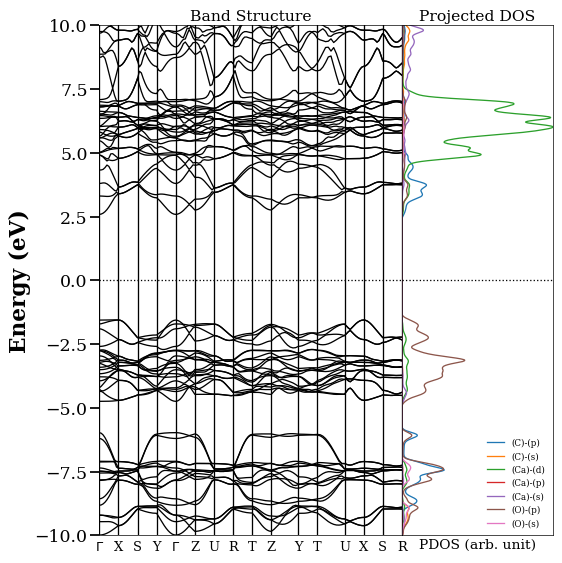

interactive(children=(FloatText(value=10.0, description='upper bound'), FloatText(value=-10.0, description='lo…

In [11]:
#I'm almost certain that there is a computationally faster way to find the right limit for the PDOS graph, but I'm not messing with the solution for now.


%matplotlib notebook
#these need to be set to whatever the default is on the graphing function below just to initialize the variable so it doesn't cause an error later
currentupper = 10.0
currentlower = -10.0
saver = 'a'
maxYvalue = 0
#create a figure with 2 distinct axese, also sets the figure size, width ratio between the graphs, and the distance between them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9), sharey=True, gridspec_kw={'width_ratios': [2, 1],'wspace':0, 'hspace':0})

#sets up the font for the whole graph (this will probably be updated later)
plt.rcParams['font.family'] = 'serif'

##########################

#make the function which graphs PDOS so that it can be called later and interacted with using the widgets. Maybe could've done this differently but whatever 
def PDOSGRAPHER(upper,lower):
    #define the global variables because I need to use these outside of this function (at least I do with the way I set everything up it probably could be done different)
    global currentlower, currentupper #currentlower/upper holds the value of the lower and upper bounds of the y axis of the graph
    #flag to check if the boundaries have been changed
    boundchange = 0
    ymax = 0
        
    if (currentlower != lower) | (currentupper != upper): #if bounds have changed, set boundary flag to 1
        boundchange = 1
    if boundchange == 1: #if boundary flag is 1, clear both axes of the figure. This eliminates doubling up the graph while changing bounds
        ax1.cla()
        ax2.cla()
        
    if folderchoice == 'y': #finds the bands.dat.gnu file
        file_location = os.path.join(file_directory,"*.dat.gnu")
        files = glob.glob(file_location)

        readfile = open(files[-1])
        xyz = readfile.readlines()#same as above

        tempx = [] #arrays that temporarily hold the x and y values until they are put together in a tuple in segments
        tempy = []
        segments = [] #array that holds the x and y tuples

    for line in xyz: #splits bands.dat.gnu into lines
        first = 'hello'
        words = line.split()
        if words != []:
            tempx.append(float(words[0])) #appends the x and y's to temp arrays
            tempy.append(float(words[1]))
        if words == []:                    #when there is a blank line, which signals the end of a line on the graph, append the x and y segments together into the segments array
            segments.append((tempx,tempy))
            tempx = []                      #reinitialize the temp arrays to wipe them
            tempy = []
    segments.append((tempx, tempy))         #append the x and y arrays again just in case there isn't a blank line at the end of the file
            
    i = 0
    for x,y in segments:                       #plots the x and y segments and sets up all the graph formatting for the first plot. It was done this way so that there aren't lines going across the graph linking the end of one line to the start of the next.
        ax1.plot(x,(y - fermi),'black')
    ax1.set_ylabel('Energy (eV)', fontsize=25,fontweight='bold')
    ax1.axhline(y=0, linestyle='dotted', color='black')
    ax1.set_xticks([])
    ax1.tick_params(axis='y', which='major', length=10, width=2, labelsize=20)
    dataX = np.loadtxt(files[0], usecols=(0), unpack = True)
    xlow = np.min(dataX)
    xhigh = np.max(dataX)
    ax1.set_xlim(xlow,xhigh)
    ax1.set_title("Band Structure", fontsize=18)
    
    if folderchoice == 'n':
        print("input file directory for *.dat.gnu file")
        file_location = os.path.join(input(),"*.dat.gnu")
        files = glob.glob(file_location)
        print(files)
        readfile = open(files[0])
        xyz = readfile.readlines()

        tempx = []
        tempy = []
        segments = []

        for line in xyz:
            first = 'hello'
            words = line.split()
            if words != []:
                tempx.append(float(words[0]))
                tempy.append(float(words[1]))
            if words == []:
                segments.append((tempx,tempy))
                tempx = []
                tempy = []
        segments.append((current_x, current_y))

        i = 0 #none of this code has been updated so I'm just gonna do it later
        for x,y in segments:
            ax1.plot(x,(y - fermi),'black')
        ax1.set_ylabel('Energy (eV)', fontsize=25)
        ax1.axhline(y=0, linestyle='dotted', color='black')
        ax1.set_xticks([])
        ax1.tick_params(axis='y', which='major', length=10, width=2, labelsize=20) #Code is the same as above but you choose your file directory  #for entering the directory with the required files manually
    
    linearray = []
    ymaxarray = []
    
    if folderchoice == 'n':
        print("Enter directory with PDOS Files")
        directory = input()
        file_location = os.path.join(directory,"*.pdos_atm#*")
        pdos_files = glob.glob(file_location)
        last_file = "a"      #saves the previously opened file 
        last_orbital = "z"   #saves orbital of the previously analyzed file
        last_element = "AAAAA"    #saves the element of the previously analyzed file
        i = 0                     #iterator, I probably could rework things to get rid of this but it's fine probably

        once = 0               #flag for checking if the loop has run once because the first file has nothing for a lot of the "previous element" code to check against
        dataYcheck = 0         #flag for when the orbital changes it puts the first orbital data into new_dataY
            
        new_dataY =np.array([])  #array for holding groups of orbital PDOS (I probably could explain this better or have titled it better but oh well)
        
        orbitaldf = pd.DataFrame(columns = ['element','orbital'])
        all_dataY = np.array([])
        all_dataX = np.array([])
        for index, row in sort.iterrows():           #iterates through the rows of the dataframe and if the x values are between the upper and lower bounds then it adds the x and y values to an array. This does not work to find the max x value in the limit for some reason :(
            
            element = row["element"]
            orbital = row["orbital"]
            filepath = row["file"]
            if ((orbitaldf["element"] == element) & (orbitaldf["orbital"] == orbital)).any():
                continue
            try:
                dataX, dataY = np.loadtxt(filepath, usecols=(0, 1), unpack=True)
                ax2.plot(dataY, dataX - fermi, label=f"{element}-{orbital}")
                all_dataY = np.append(all_dataY,dataY)
                all_dataX = np.append(all_dataX,(dataX-fermi))    #I WASN'T ACCOUNTING FOR THE FERMI LEVEL OMG
                new_row = pd.DataFrame([{'element': element, 'orbital': orbital}])
                orbitaldf = pd.concat([orbitaldf, new_row], ignore_index=True)
            except:
                pass
        lineframe = pd.DataFrame({"pdos":all_dataY,"energy":all_dataX}) #make a data frame with all the values of x and y
        ymaxvalues = np.array([])                                       #make a array to hold all of the maximum values of y
        for index, row in lineframe.iterrows():                         #iterate through the df
            if (row["energy"] >= lower) & (row["energy"] <= upper):     #check to see if the x value is withing the bounds, and if it is then append the y values to the array
                ymaxvalues= np.append(ymaxvalues,row["pdos"])
            else:
                pass
        plt.legend()

        #all the axis formatting stuff
        ymin = np.min(all_dataY)
        ymax = np.max(ymaxvalues) #take the maximum y value in the range in order to find where to place the limit on the right edge of the x axis
        ax2.set_xlim(ymin,ymax)
        ax2.axhline(y=0, linestyle='dotted', color='black')   #change to allow for choosing the thickness of the lines later (actually do that above for the graph lines too, although I think there's a better way to do that)
        ax2.set_xticks([])
        ax2.tick_params(axis='y', which='major', length=0, width=0, labelsize=0)
        ax2.set_xlabel("PDOS (arb. unit)", fontsize=16)
        ax2.set_title("Projected DOS", fontsize=18)
        ax2.legend(frameon = False)
        lowest = np.min((dataX-fermi))   #you know I think I actually couldn't get this to work, I could probably delete it

        ax1.set_ylim(float(lower),float(upper))   #allows for the input of the upper and lower bounds for the y axis of the graph
        
        i = 0            #reset the iterator to 0 (was it even used?)
        try:
            for i, value in enumerate(sym_xvalue):  #iterate through the values in the symmetry points
                ax1.axvline(x=value, color='black')
                ax1.text(value, lower - .6, sym_points[i], fontsize=15, ha = 'center')   #place the symbol for the value slightly under the graph, centered on the line. This actually breaks if you put it too far down, but I don't think it matter
                i += 1
        except:   #I think this was just a failsafe for when it hit the end? I might've been overthinking tbh. or maybe it was so I could test it when I couldn't pull the values
            pass
        plt.tight_layout()    #tightens up the plots, although honestly I don't think it does anything
        currentlower = lower  #sets the currentlower/upper levels which are used at the top of the function
        currentupper = upper
    
    if folderchoice == 'y':
#         file_location = os.path.join(file_directory,"*.pdos_atm#*")  #same as above
#         pdos_files = glob.glob(file_location)
        
        
        last_file = "a"      #saves the previously opened file 
        last_orbital = "z"   #saves orbital of the previously analyzed file
        last_element = "AAAAA"    #saves the element of the previously analyzed file
        i = 0                     #iterator, I probably could rework things to get rid of this but it's fine probably

        once = 0               #flag for checking if the loop has run once because the first file has nothing for a lot of the "previous element" code to check against
        dataYcheck = 0         #flag for when the orbital changes it puts the first orbital data into new_dataY
            
        new_dataY =np.array([])  #array for holding groups of orbital PDOS (I probably could explain this better or have titled it better but oh well)
        
        orbitaldf = pd.DataFrame(columns = ['element','orbital'])
        all_dataY = np.array([])
        all_dataX = np.array([])
        for index, row in sort.iterrows():           #iterates through the rows of the dataframe and if the x values are between the upper and lower bounds then it adds the x and y values to an array. This does not work to find the max x value in the limit for some reason :(
            
            element = row["element"]
            orbital = row["orbital"]
            filepath = row["file"]
            if ((orbitaldf["element"] == element) & (orbitaldf["orbital"] == orbital)).any():
                continue
            try:
                dataX, dataY = np.loadtxt(filepath, usecols=(0, 1), unpack=True)
                ax2.plot(dataY, dataX - fermi, label=f"{element}-{orbital}")
                all_dataY = np.append(all_dataY,dataY)
                all_dataX = np.append(all_dataX,(dataX-fermi))    #I WASN'T ACCOUNTING FOR THE FERMI LEVEL OMG
                new_row = pd.DataFrame([{'element': element, 'orbital': orbital}])
                orbitaldf = pd.concat([orbitaldf, new_row], ignore_index=True)
            except:
                pass
        lineframe = pd.DataFrame({"pdos":all_dataY,"energy":all_dataX}) #make a data frame with all the values of x and y
        ymaxvalues = np.array([])                                       #make a array to hold all of the maximum values of y
        for index, row in lineframe.iterrows():                         #iterate through the df
            if (row["energy"] >= lower) & (row["energy"] <= upper):     #check to see if the x value is withing the bounds, and if it is then append the y values to the array
                ymaxvalues= np.append(ymaxvalues,row["pdos"])
            else:
                pass
        plt.legend()

        #all the axis formatting stuff
        ymin = np.min(all_dataY)
        ymax = np.max(ymaxvalues) #take the maximum y value in the range in order to find where to place the limit on the right edge of the x axis
        ax2.set_xlim(ymin,ymax)
        ax2.axhline(y=0, linestyle='dotted', color='black')   #change to allow for choosing the thickness of the lines later (actually do that above for the graph lines too, although I think there's a better way to do that)
        ax2.set_xticks([])
        ax2.tick_params(axis='y', which='major', length=0, width=0, labelsize=0)
        ax2.set_xlabel("PDOS (arb. unit)", fontsize=16)
        ax2.set_title("Projected DOS", fontsize=18)
        ax2.legend(frameon = False)
        lowest = np.min((dataX-fermi))   #you know I think I actually couldn't get this to work, I could probably delete it

        ax1.set_ylim(float(lower),float(upper))   #allows for the input of the upper and lower bounds for the y axis of the graph
        
        i = 0            #reset the iterator to 0 (was it even used?)
        try:
            for i, value in enumerate(sym_xvalue):  #iterate through the values in the symmetry points
                ax1.axvline(x=value, color='black')
                ax1.text(value, lower - .6, sym_points[i], fontsize=15, ha = 'center')   #place the symbol for the value slightly under the graph, centered on the line. This actually breaks if you put it too far down, but I don't think it matter
                i += 1
        except:   #I think this was just a failsafe for when it hit the end? I might've been overthinking tbh. or maybe it was so I could test it when I couldn't pull the values
            pass
        plt.tight_layout()    #tightens up the plots, although honestly I don't think it does anything
        currentlower = lower  #sets the currentlower/upper levels which are used at the top of the function
        currentupper = upper
    plt.show()                #makes the graph interactive (iirc)
    
#################Function ends########################
interact(PDOSGRAPHER, upper = widgets.FloatText(value=10,description='upper bound',disabled=False),
         lower = widgets.FloatText(value=-10,description='lower bound',disabled=False))               #function is called, the lower and upper bounds are defined by a widget which allows the user to input floats. When the float is updated, the graph is wiped and redrawn. I expect to put more functions here when I add more functionality later.
button = widgets.Button(            #creates a button :)
    description='Save',
    disabled=False,
    button_style='', 
    tooltip='Click me',
    icon='check'
)
format_dropdown = widgets.Dropdown(             #adds a dropdown menu which allows you to choose to save as a pdf or eps file. it defaults to pdf because that's convenient to me, but I can change default to eps later if people want me to. 
    options=[('PDF', 'pdf'), ('EPS', 'eps')],
    description='File Format:'
)

def save(b):                   #function for the button, so that when you press it the figure is saved to whatever format you choose it to be saved to
    print("saved!")
    savetype = format_dropdown.value
    if savetype == "pdf":
        fig.savefig(textbox.value + ".pdf", format="pdf")
    if savetype == "eps":
        fig.savefig(textbox.value + " PDOS.eps", format="eps")
textbox = widgets.Text(
    value =compound + ' PDOS',
    placeholder='Type something',
    description='File name:',
    disabled=False
)
button #spawns button
button.on_click(save)      #says that when the button is clicked, execute the save function
ui = widgets.HBox([format_dropdown,textbox, button])    #creates a ui which clumps the widgets that aren't directly linked to the graph horizontally
display(ui) #spawns ui